In [1]:
import cv2
import sys
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Qingyu\Anaconda3\envs\2040project\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FACE_DEFAULT_SHAPE = (160, 160)

In [3]:
siamese_model = model_from_json(open("Model1.json", "r").read())
siamese_model.load_weights('Model1.h5')

In [4]:
# reference to
# https://gist.github.com/tilfin/98bbba47fdc4ac10c4069cce5fabd834

class FaceCropper(object):
    CASCADE_PATH = "./data/haarcascades/haarcascade_frontalface_default.xml"

    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(self.CASCADE_PATH)

    def generate(self, image_path):
        img = cv2.imread(image_path)
        if (img is None):
            print("Can't open image file")
            return False

        faces = self.face_cascade.detectMultiScale(img, 1.1, 3, minSize=(100, 100))
        if len(faces) == 0:
#             print('Failed to detect face')
            # return resized original image
            return cv2.resize(img, FACE_DEFAULT_SHAPE).astype(float)
        
        max_size = 0
        max_index = 0
        for i, (x, y, w, h) in enumerate(faces):
            if w * h > max_size:
                max_size = w * h
                max_index = i
        (x,y,w,h) = faces[i]
        r = max(w, h) / 2
        centerx = x + w / 2
        centery = y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)
        
        faceimg = img[ny:ny+nr, nx:nx+nr]
        lastimg = cv2.resize(faceimg, FACE_DEFAULT_SHAPE)
        return lastimg.astype(float)/255.0

In [5]:
def preprocess_face(face):
    face = np.expand_dims(face, axis=0)
#     face = preprocess_input(face)
    return face

In [6]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [7]:
# reference to
# https://github.com/serengil/tensorflow-101/blob/master/python/facenet.ipynb

metric = "euclidean" #euclidean or cosine
PATH = './data/lfw/lfw-deepfunneled/'

def is_same_person(model, img1, img2, metric, threshold):  
    # crop face
    detecter = FaceCropper()
    face1 = preprocess_face(detecter.generate(PATH+img1))
    face2 = preprocess_face(detecter.generate(PATH+img2))
    
    # if either of the images cannot crop a face
    # return False
    if isinstance(face1, bool) or isinstance(face2, bool):
        return False
    else:
        # produce 128-dimensional representation
        
        
        img1_representation = model.predict([face1, face1, face1])[0,:128]
        img2_representation = model.predict([face2, face2, face2])[0,:128]

        if metric == "euclidean":
            img1_representation = l2_normalize(img1_representation)
            img2_representation = l2_normalize(img2_representation)
            euclidean_distance = findEuclideanDistance(img1_representation, img2_representation)
            return euclidean_distance < threshold

        elif metric == "cosine":
            cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
            return cosine_similarity < threshold

In [8]:
my_cols = ['A', 'B', 'C', 'D']
pairs = pd.read_csv(PATH + 'pairs.txt', sep='\t', names=my_cols, skiprows=1)

def is_match_pair(pair):
    return np.isnan(pair[3])

def eval_lfw(model, pairs, metric, threshold):
    nrows = pairs.shape[0]
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i, pair in pairs.iterrows():
        if is_match_pair(pair):
            img1 = pair[0]+'\\'+pair[0]+'_'+format(pair[1], '04d')+'.jpg'
            img2 = pair[0]+'\\'+pair[0]+'_'+format(int(pair[2]), '04d')+'.jpg'
            if is_same_person(model, img1, img2, metric, threshold):
                true_positive += 1
            else:
                false_negative += 1
                pass
        else:
            img1 = pair[0]+'\\'+pair[0]+'_'+format(pair[1], '04d')+'.jpg'
            img2 = pair[2]+'\\'+pair[2]+'_'+format(int(pair[3]), '04d')+'.jpg'
            if not is_same_person(model, img1, img2, metric, threshold):
                true_negative += 1
            else:
                false_positive += 1
                pass
    true_positive_rate = true_positive / nrows
    true_negative_rate = true_negative / nrows
    false_positive_rate = false_positive / nrows
    false_negative_rate = false_negative / nrows
    return true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate

In [9]:
def find_best_threshold(threshold_list, metric, sample_num=100):
    accuracy_list = []
    detection_rate_list = []
    false_alarm_rate_list = []
    pair_samples = pairs.sample(sample_num, random_state=0)
    best_accuracy = 0
    best_threshold = 0
    
    for threshold in threshold_list:
        a, b, c, d = eval_lfw(siamese_model, pair_samples, metric, threshold)
        accuracy = a + b
        detection_rate = a / (a + d)
        false_alarm_rate = c / (c + b)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
        accuracy_list.append(accuracy)
        detection_rate_list.append(detection_rate)
        false_alarm_rate_list.append(false_alarm_rate)

    print('Best threshold is', best_threshold)
    print('Best accuracy is', best_accuracy)

    fig = plt.figure(figsize=(4,6))
    fig.add_subplot(2,1, 1)
    plt.plot(threshold_list, accuracy_list)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')

    fig.add_subplot(2,1, 2)
    plt.plot(false_alarm_rate_list, detection_rate_list)
    plt.xlabel('FAR')
    plt.ylabel('DR')

## Find a best threshold for euclidean distance

Best threshold is 0.8500000000000001
Best accuracy is 0.94
Wall time: 1min 19s


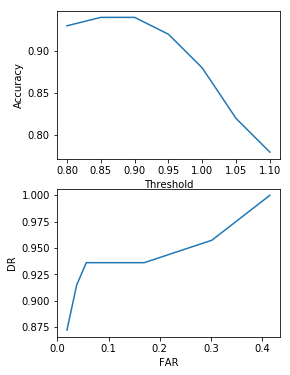

In [10]:
%%time
find_best_threshold(np.arange(0.8,1.1,0.05), 'euclidean')

Best threshold is 0.9400000000000002
Best accuracy is 0.9183333333333333
Wall time: 21min 32s


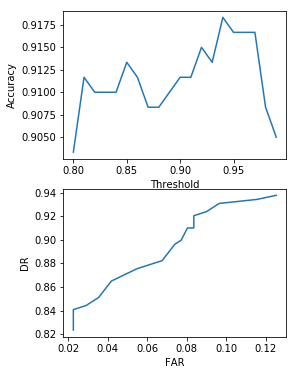

In [11]:
%%time
find_best_threshold(np.arange(0.8,1.0,0.01), 'euclidean', sample_num=600)

In [12]:
EUCLIDEAN_THRESHOLD = 0.94

### The best threshold for euclidean distance is 0.94

## Find the best threshold for cosine similarity

Best threshold is 0.35
Best accuracy is 0.94
Wall time: 2min 21s


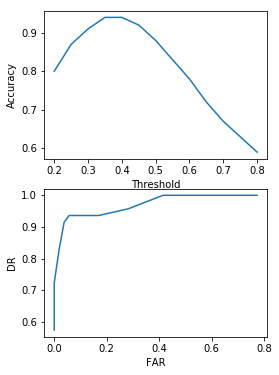

In [13]:
%%time
find_best_threshold(np.arange(0.2,0.8,0.05), 'cosine')

Best threshold is 0.4500000000000001
Best accuracy is 0.9166666666666667
Wall time: 21min 35s


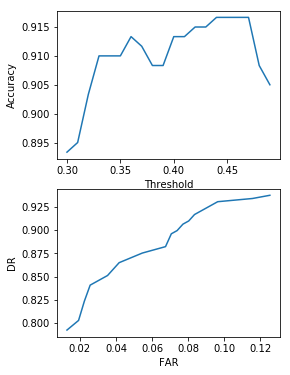

In [14]:
%%time
find_best_threshold(np.arange(0.3,0.5,0.01), 'cosine', sample_num=600)

In [15]:
COSINE_THRESHOLD = 0.45

### The best threshold for cosine similarity is 0.45

## Test on 6000 pairs of LFW dataset

### Euclidean distance can achive slightly higher accuracy

In [17]:
%%time
a, b, c, d = eval_lfw(siamese_model, pairs, 'euclidean', EUCLIDEAN_THRESHOLD)
accuracy = (a + b)/(a + b + c + d)

Wall time: 10min 54s


In [18]:
accuracy

0.9028333333333334